In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PyraLNet as pyral
import SteadNet as stead
import Dataset
%matplotlib inline

# Task: Solve the Bar-task with PyraLNet and SteadNet with a 9x30x3, soft ReLU network

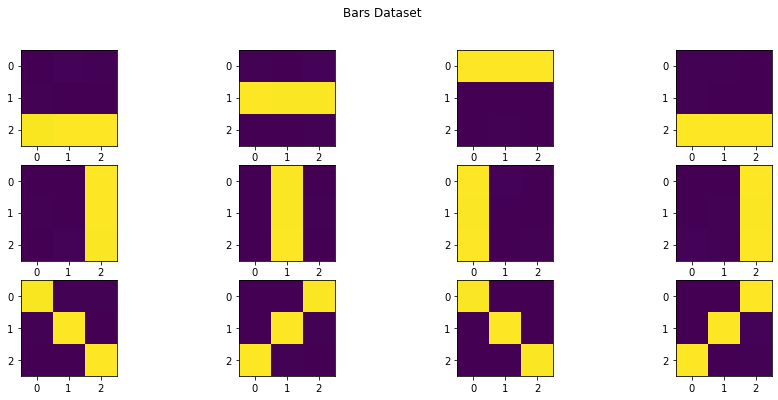

In [2]:
# How does the bar-dataset look like?
# get 4 samples per class on a 3x3 grid
X, Y = Dataset.BarsDataset(3, samples_per_class=4)[:]

# rows correspond to the 3 different classes and columns are corresponding (random) realisations
plt.figure(figsize=(15,6))
plt.suptitle("Bars Dataset")
for i in range(4):
    plt.subplot(3,4,i+1)
    Dataset.plot_bars(X[np.argwhere(Y == 0).flatten()[i]], 3)
for i in range(4):
    plt.subplot(3, 4, i + 5)
    Dataset.plot_bars(X[np.argwhere(Y == 1).flatten()[i]], 3)
for i in range(4):
    plt.subplot(3,4,i + 9)
    Dataset.plot_bars(X[np.argwhere(Y == 2).flatten()[i]], 3)
plt.show()

In [6]:
# Now let's try to solve this classification task using PyraLNet

# first we need the training and validation datasets
X_train, Y_train = Dataset.BarsDataset(3, samples_per_class=500, seed=50)[:]
X_val, Y_val = Dataset.BarsDataset(3, samples_per_class=100)[:]


# define the parameters (these parameters are pretty "standard") for a 9x30x3 network
params = {"dims": [9, 30, 3], "dt": 0.1, "gl": 0.1, "gb": 1.0, "ga": 0.8, "gd": 1.0, "gsom": 0.8,
          "eta": {"up": [0.02, 0.01], "pi": [0.02, 0], "ip": [0.02, 0]},
          "bias": {"on": False, "val": 0.0},
          "init_weights": {"up": 1, "down": 1, "pi": 1, "ip": 1}, "tau_w": 30, "noise": 0, "t_pattern": 100,
          "out_lag": 80, "tau_0": 3, "learning_lag": 0, "reset_deltas": False}


feedback-couplings: lambda_out = 0.421053, lambda_inter = 0.421053, lambda_hidden = 0.421053
10 validations per epoch
t_pattern: 100.000 ms,	rec_dt: 100.000 ms
out-lag: 80.000 ms,	learning-lag: 0.000 ms
100/3400 input patterns done. About 26min and 43s left.
---Validating on 20 patterns---
mean squared error: 0.536632
accuracy: 0.300000
200/3400 input patterns done. About 19min and 16s left.
300/3400 input patterns done. About 16min and 8s left.
---Validating on 20 patterns---
mean squared error: 0.080554
accuracy: 0.850000
400/3400 input patterns done. About 14min and 9s left.
500/3400 input patterns done. About 17min and 1s left.
---Validating on 20 patterns---
mean squared error: 0.137226
accuracy: 0.850000
600/3400 input patterns done. About 22min and 0s left.
---Validating on 20 patterns---
mean squared error: 0.076203
accuracy: 0.600000
700/3400 input patterns done. About 16min and 7s left.
800/3400 input patterns done. About 16min and 47s left.
---Validating on 20 patterns---
me

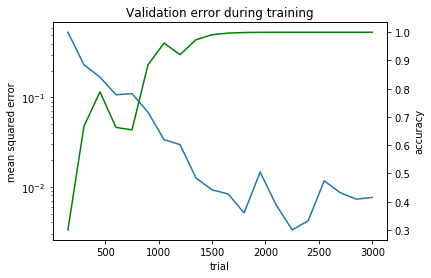

In [7]:
# create the network with soft ReLU activation function
simNet = pyral.Net(params, seed=42)

# we want to record the forward weight evolution for later
rec_quants = [["W_up"], ["W_up"]]

# to speed up training we directly start in the self-predicting state
simNet.reflect()

# train for 2 epochs with 10 validations per epoch on blocks of 20 randomly drawn samples from the validation set
# the target label is 1-hot coded, s.t. the target potential takes values in {0.1, 1.0}
# the weigths matrices will be recorded with a resolution of 100ms (the pattern time)
records, T, r_in, u_trgt, out_seq, val_res = simNet.train(X_train, Y_train, X_val, Y_val, n_epochs=2, val_len=20,
                                                       vals_per_epoch=10, n_out=3, classify=True, u_high=1.0,
                                                       u_low=0.1, rec_quants=rec_quants, rec_dt=100,
                                                       metric=pyral.accuracy)

# plot exponential moving average of validation error
plt.title("Validation error during training")
plt.semilogy(val_res[:, 0], pyral.ewma(val_res[:, 1], round(len(val_res) / 10)), label="mse")
plt.xlabel("trial")
plt.ylabel("mean squared error")
ax2 = plt.gca().twinx()
ax2.plot(val_res[:, 0], pyral.ewma(val_res[:, 2], round(len(val_res) / 10)), c="g", label="accuracy")
ax2.set_ylabel("accuracy")
plt.show()

feedback-couplings: lambda_out = 0.421053, lambda_inter = 0.421053, lambda_hidden = 0.421053
10 validations per epoch
each input pattern is presented 10 times -> dT/tau_w: 0.333
effective learning rate multiplier: 10.000000
---Validating on 20 patterns---
mean squared error: 0.584045
accuracy: 0.550000
---Validating on 20 patterns---
mean squared error: 0.077151
accuracy: 0.800000
---Validating on 20 patterns---
mean squared error: 0.130010
accuracy: 0.850000
---Validating on 20 patterns---
mean squared error: 0.079504
accuracy: 0.800000
---Validating on 20 patterns---
mean squared error: 0.143925
accuracy: 0.650000
1000/3400 input patterns done. About 17s left.
---Validating on 20 patterns---
mean squared error: 0.053670
accuracy: 1.000000
---Validating on 20 patterns---
mean squared error: 0.020491
accuracy: 1.000000
---Validating on 20 patterns---
mean squared error: 0.029602
accuracy: 0.900000
---Validating on 20 patterns---
mean squared error: 0.005341
accuracy: 1.000000
---Valida

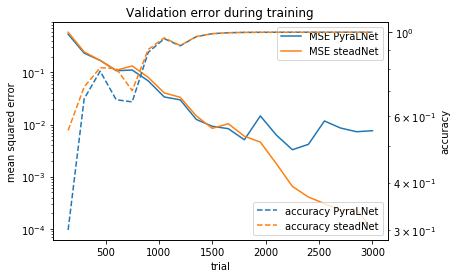

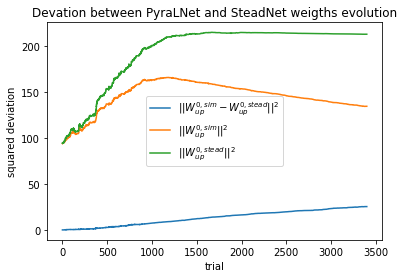

In [14]:
# How does this compare to the steady-state approximation?

steadNet = stead.Net(params, seed=42)
steadNet.reflect()

# Since we use a sof ReLU activation function one has to be a little bit careful regarding the stability of
# the network (especially SteadNet) -> increase n_exposures to 10
records_stead, out_seq_stead, val_res_stead = steadNet.train(X_train, Y_train, X_val, Y_val, n_epochs=2, val_len=20,
                                                    vals_per_epoch=10, n_out=3, classify=True, u_high=1.0,
                                                    u_low=0.1, metric=pyral.accuracy, n_exposures=10, n_passes=2,
                                                    rec_quants=rec_quants, rec_dn=1)


# plot exponential moving average of validation error
plt.title("Validation error during training")
plt.semilogy(val_res[:, 0], pyral.ewma(val_res[:, 1], round(len(val_res) / 10)), label="MSE PyraLNet")
plt.semilogy(val_res_stead[:, 0], pyral.ewma(val_res_stead[:, 1], round(len(val_res) / 10)), label="MSE steadNet")
plt.xlabel("trial")
plt.ylabel("mean squared error")
plt.legend()
ax2 = plt.gca().twinx()
plt.semilogy(val_res[:, 0], pyral.ewma(val_res[:, 2], round(len(val_res) / 10)), ls="--", c="C0", label="accuracy PyraLNet")
plt.semilogy(val_res_stead[:, 0], pyral.ewma(val_res_stead[:, 2], round(len(val_res) / 10)), ls="--", c="C1", label="accuracy steadNet")
ax2.set_ylabel("accuracy")
plt.legend()
plt.show()

plt.title("Devation between PyraLNet and SteadNet weigths evolution")
plt.plot(np.sum((records[0]["W_up"].data - records_stead[0]["W_up"].data) ** 2, axis=(1,2)), label="$||W_{up}^{0,sim}-W_{up}^{0, stead}||^2$")
plt.plot(np.sum((records[0]["W_up"].data) ** 2, axis=(1,2)), label="$||W_{up}^{0,sim}||^2$")
plt.plot(np.sum((records_stead[0]["W_up"].data) ** 2, axis=(1,2)), label="$||W_{up}^{0,stead}||^2$")
plt.xlabel("trial")
plt.ylabel("squared deviation")
plt.legend()
plt.show()


# PyraLNet as well as SteadNet are able to solve the task effectively
# However, note the discrepancy in validation error (MSE) beyond 2000 trials (PyraLNet MSE saturates -> learning-lag)!
# now play around with n_passes, n_exposures and learning-lag and see what happens!